<h1>Datetime recognizer</h1>
Train a model to recognize any datetimes in a given text string. 

Start with simple iso8601s and then progress to locales, timezones, countries & conventions.


Starting from the Keras autoencoder example.

In [2]:
import os

os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda/lib64'
os.environ['CUDA_HOME'] = '/usr/local/cuda'

In [22]:
# -*- coding: utf-8 -*-
'''An implementation of sequence to sequence learning to decode localized datetimes from strings
Input: "Monday 31 December 2007 07:07:07.0000000 +02:00 CET/Europe"
or
       "Monday, 24 October 1977 at 09:10:55 Greenwich Mean Time"
Output: "2007-12-31T07:07:07.00000+02:00"
Padding is handled by using a repeated sentinel character (space)


Input may optionally be inverted, shown to increase performance in many tasks in:
"Learning to Execute"
http://arxiv.org/abs/1410.4615
and
"Sequence to Sequence Learning with Neural Networks"
http://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf
Theoretically it introduces shorter term dependencies between source and target.

'''
from keras.models import Sequential
from keras.engine.training import slice_X
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, recurrent
from keras.optimizers import Adam, SGD, RMSprop
import numpy as np
from six.moves import range
import pytz
from datetime import datetime, timezone
import itertools
import random
from babel import Locale, localedata, UnknownLocaleError
from babel.dates import format_datetime
from tqdm import tqdm
import sys
import string

In [4]:
import matplotlib.pyplot as plt
import math

In [5]:
%matplotlib inline

In [6]:
class CharacterTable(object):
    '''
    Given a set of characters:
    + Encode them to a one hot integer representation
    + Decode the one hot integer representation to their character output
    + Decode a vector of probabilities to their character output
    '''
    def __init__(self, country_codes, maxlen):
        self.chars = set(string.ascii_letters + 
                         string.punctuation + 
                         string.digits
                        )

        ts_from = int(datetime(1980, 1, 1, tzinfo=timezone.utc).timestamp())
        ts_to   = int(datetime(1981, 1, 1, tzinfo=timezone.utc).timestamp())
        tstamps = [t for t in range(ts_from, ts_to, 60*1000)]
        retries = 0
        
        #Hoover up all the non-ascii characters that might be needed
        for country_code in tqdm(country_codes):
            try:                            
                if pytz.country_timezones.get(country_code):
                    for ctzone in pytz.country_timezones(country_code):
                        tzone = pytz.timezone(ctzone)
                        country_locale = Locale.parse('und_' + country_code)
                        for fmt  in ['short',' medium','long','full']:
                            ydts = [datetime.utcfromtimestamp(t).replace(tzinfo=tzone) for t in tstamps]
                            if random.choice([True, False]):
                                X = [format_datetime(dt, format=fmt, locale=country_locale) for dt in ydts]
                            else:
                                sep = random.choice([' ','T'])
                                X = [dt.isoformat(sep) for dt in ydts]

                            # So that's a years worth of datetimes for all the countrys & locales & timezones 
                            for ln in X:
                                # Going with case sensitive because some dt formats have an "i"
                                self.chars = self.chars.union( set(iter(ln)))
                                
            except UnknownLocaleError:                    
                if retries >=21:
                    raise # Somethings gone wrong!

        self.chars = sorted(self.chars)

        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
        self.maxlen = maxlen

    def encode(self, C, maxlen=None):
        maxlen = maxlen if maxlen else self.maxlen
        X = np.zeros((maxlen, len(self.chars)))
        for i, c in enumerate(C[:maxlen]):
            X[i, self.char_indices[c]] = 1
        return X

    def decode(self, X, calc_argmax=True):
        if calc_argmax:
            X = X.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in X)

In [7]:
#ctable = CharacterTable(COUNTRY_CODES, MAXLEN_X)
#ctable.chars

In [8]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [9]:
def DateTimeDataGenerator(sample_size):   
    while True:        
        # 0xFFFFFFFF 32 bit unsigned max 2106
        # 0x7FFFFFFF 32 bit   signed max 2038
        tstamps = [random.randrange(0xFFFFFFFF) for _ in range(sample_size)]

        yield tstamps


In [10]:
def DateTimeIsoGenerator(country_codes, sample_size, maxlen_x, maxlen_y, invert):
    """Simplest case for training, straing 86012, no timezone.
    """
    dtdg = DateTimeDataGenerator(sample_size)
    
    while True:        
        # 0xFFFFFFFF 32 bit unsigned max 2106
        # 0x7FFFFFFF 32 bit   signed max 2038
        tstamps = next(dtdg)

        ydts = [datetime.utcfromtimestamp(t).isoformat('T') for t in tstamps]
        sep = random.choice([' ','T'])
        X = [datetime.utcfromtimestamp(t).isoformat(sep) for t in tstamps] 

        # pad or chop to length
        X    = [(pp + (' '*maxlen_x))[:maxlen_x] for pp in X]
        ydts = [(pp + (' '*maxlen_y))[:maxlen_y] for pp in ydts]
        
        if invert:
            X = [xx[::-1] for xx in X]
            
        yield (X, ydts)

In [11]:
def DateTimeFormattedGenerator(country_codes, sample_size, maxlen_x, maxlen_y, invert):
    dtdg = DateTimeDataGenerator(sample_size)
    all_locales = localedata.locale_identifiers()
    
    while True:        
        # 0xFFFFFFFF 32 bit unsigned max 2106
        # 0x7FFFFFFF 32 bit   signed max 2038
        tstamps = next(dtdg)

        # Pick a country and timezone
        for retries in range(32):
            try:
                country_code = random.choice(country_codes)
                timezone = pytz.timezone(random.choice(pytz.country_timezones(country_code)))
                country_locale = Locale.parse('und_' + country_code)
                break
            except UnknownLocaleError:
                print('UnknownLocaleError: %s'%'und_' + country_code, file=sys.stderr)
                if retries >=31:
                    raise # Somethings gone wrong!
                    
        ydts = [datetime.utcfromtimestamp(t).replace(tzinfo=timezone).isoformat('T') for t in tstamps]
        

        fmt = random.choice(['short',' medium','long','full'])
        X = [format_datetime(datetime.utcfromtimestamp(t).replace(tzinfo=timezone), 
                             format=fmt, 
                             locale=country_locale
                            ) for t in tstamps]

        # pad or chop to length
        X    = [(pp + (' '*maxlen_x))[:maxlen_x] for pp in X]
        ydts = [(pp + (' '*maxlen_y))[:maxlen_y] for pp in ydts]
        
        if invert:
            X = [xx[::-1] for xx in X]
            
        yield (X, ydts)

In [12]:
def DateTimeVectorGenerator(dt_generator, ctable):    
    X_next, y_next = next(dt_generator)
    while True:
        # X_next are all the same MAXLEN_X length. Same for y_next
        X = np.zeros((len(X_next), len(X_next[0]), len(ctable.chars)), dtype=np.bool)
        y = np.zeros((len(y_next), len(y_next[0]), len(ctable.chars)), dtype=np.bool)
        
        for i, sentence in enumerate(X_next):
            X[i] = ctable.encode(sentence, len(X_next[0]))
            
        for i, sentence in enumerate(y_next):
            y[i] = ctable.encode(sentence, len(y_next[0]))
        
        yield X, y

In [13]:
def visualize_history(learning_hist, data_filename=None):    
    plt.figure(figsize=(12, 6))
    discard = int(math.ceil(len(learning_hist)/100))*5
    # skip the first few, they destroy plot scale
    plt.plot([i.history['loss']     for i in learning_hist][discard:], label='loss')
    plt.plot([i.history['val_loss'] for i in learning_hist][discard:], label='val_loss')

    plt.ylabel('error')
    plt.xlabel('iteration')
    plt.legend()
    #plt.ylim([0, 0.005])
    plt.title('training error')
    if (data_filename is not None):
        plt.savefig(data_filename)
        plt.close()
    else:
        plt.show()

In [23]:
# Parameters for the model and dataset
TRAINING_SIZE   = 1111 #gn1 #50000
VALIDATION_SIZE = 111
INVERT = True
# Try replacing GRU, or SimpleRNN
RNN = recurrent.GRU

BATCH_SIZE = 8
LAYERS = 1
MAXLEN_X = 72 # longer than anything expected like 'Monday 31 December 2000 07:07:07.0000000 +02:00 CET/Europe'
MAXLEN_Y = len(datetime.now().isoformat(' '))
COUNTRY_CODES = ['GB', ] #'US','DE','FR','ES','IT','CA', 'NO','SE','DK','FI','EE','CZ','PL'] # pytz.country_names.keys()

HIDDEN_SIZE = MAXLEN_X * 5

In [24]:
ctable = CharacterTable(COUNTRY_CODES, MAXLEN_X)

100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


In [25]:
gen_dt = DateTimeIsoGenerator(COUNTRY_CODES, TRAINING_SIZE, MAXLEN_X, MAXLEN_Y, INVERT)
#gen_dt = DateTimeFormattedGenerator(COUNTRY_CODES, TRAINING_SIZE, MAXLEN_X, MAXLEN_Y, INVERT)

gen_vec_train      = DateTimeVectorGenerator(gen_dt, ctable)
gen_vec_validation = DateTimeVectorGenerator(gen_dt, ctable)

X_train, y_train = next(gen_vec_train)
print('X_train.shape: %s'%str(X_train.shape))
print('y_train.shape: %s'%str(y_train.shape))

X_train.shape: (1111, 72, 95)
y_train.shape: (1111, 26, 95)


In [31]:
print('Build model...')
model = Sequential()
# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE
# note: in a situation where your input sequences have a variable length,
# use inputhttps://scherbatsky.local:8000/notebooks/ml/datetime%20autoencoder-Copy1.ipynb#_shape=(None, nb_feature).
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN_X, len(ctable.chars))))
# For the decoder's input, we repeat the encoded input for each time step
model.add(RepeatVector(MAXLEN_Y))
# The decoder RNN could be multiple layers stacked or a single layer
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

# For each of step of the output sequence, decide which character should be chosen
model.add(TimeDistributed(Dense(len(ctable.chars))))
model.add(Activation('softmax'))
opt = RMSprop(lr=0.01, decay=0.95)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

Build model...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
gru_7 (GRU)                      (None, 360)           492480      gru_input_4[0][0]                
____________________________________________________________________________________________________
repeatvector_4 (RepeatVector)    (None, 26, 360)       0           gru_7[0][0]                      
____________________________________________________________________________________________________
gru_8 (GRU)                      (None, 26, 360)       778680      repeatvector_4[0][0]             
____________________________________________________________________________________________________
timedistributed_4 (TimeDistribute(None, 26, 95)        34295       gru_8[0][0]                      
____________________________________________________________________________

In [32]:
learning_hist = []
gen_dt_test = DateTimeIsoGenerator(COUNTRY_CODES, TRAINING_SIZE, MAXLEN_X, MAXLEN_Y, INVERT)
#gen_dt_test = DateTimeFormattedGenerator(COUNTRY_CODES, TRAINING_SIZE, MAXLEN_X, MAXLEN_Y, INVERT)

gen_vec_test = DateTimeVectorGenerator(gen_dt_test, ctable)

X_test, y_test = next(gen_vec_test)


--------------------------------------------------
Iteration 1
Epoch 1/1
69993/69993 [==============================] - 40s - loss: 2.1977 - acc: 0.3764 - val_loss: 1.6809 - val_acc: 0.5177
--------------------------------------------------
Iteration 2
Epoch 1/1
69993/69993 [==============================] - 37s - loss: 1.5851 - acc: 0.5306 - val_loss: 1.4802 - val_acc: 0.5863
--------------------------------------------------
Iteration 3
Epoch 1/1
69993/69993 [==============================] - 41s - loss: 1.3981 - acc: 0.5977 - val_loss: 1.3155 - val_acc: 0.6130
--------------------------------------------------
Iteration 4
Epoch 1/1
69993/69993 [==============================] - 41s - loss: 1.2495 - acc: 0.6098 - val_loss: 1.1863 - val_acc: 0.6150
--------------------------------------------------
Iteration 5
Epoch 1/1
69993/69993 [==============================] - 37s - loss: 1.1401 - acc: 0.6179 - val_loss: 1.1119 - val_acc: 0.6140
Q 2082-12-26 01:57:13                             

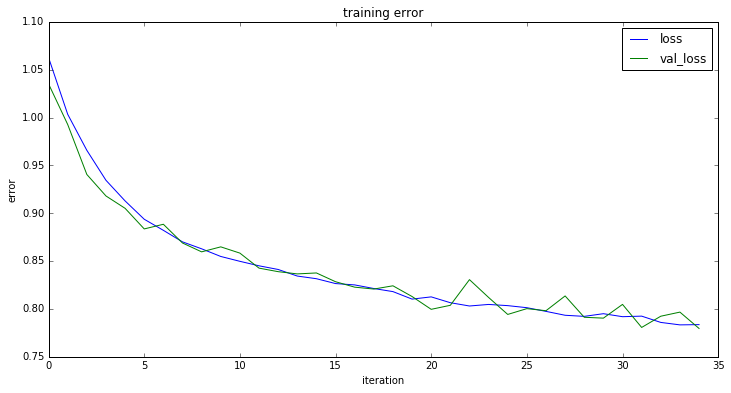

In [33]:
# Train the model each generation and show predictions against the validation dataset

for iteration in range(1, 40+1):
    print('-' * 50)
    print('Iteration', iteration)
    
    # switch locale (probably)
    gen_dt_train = DateTimeIsoGenerator(COUNTRY_CODES, TRAINING_SIZE, MAXLEN_X, MAXLEN_Y, INVERT)  
    gen_dt_val   = DateTimeIsoGenerator(COUNTRY_CODES, VALIDATION_SIZE, MAXLEN_X, MAXLEN_Y, INVERT)
    ## or
    #gen_dt_train = DateTimeFormattedGenerator(COUNTRY_CODES, TRAINING_SIZE, MAXLEN_X, MAXLEN_Y, INVERT)
    #gen_dt_val   = DateTimeFormattedGenerator(COUNTRY_CODES, VALIDATION_SIZE, MAXLEN_X, MAXLEN_Y, INVERT)

    gen_vec_train      = DateTimeVectorGenerator(gen_dt_train, ctable)
    gen_vec_validation = DateTimeVectorGenerator(gen_dt_val,   ctable)
    
    learning_hist.append(
            model.fit_generator( gen_vec_train, 
                                samples_per_epoch=69993, 
                                nb_epoch=1, 
                                verbose=1, 
                                #callbacks=[], 
                                validation_data=gen_vec_validation, 
                                nb_val_samples=VALIDATION_SIZE, 
                                #class_weight={}, 
                                #max_q_size=10, 
                                #nb_worker=1, 
                                #pickle_safe=False
                               )
            )
    ###
    # Select 3 samples from the test set so we can visualize errors
    if iteration % 5 == 0:         
        model.save('./data/datatime_autoencoder_model.h5')
        for i in range(3):
            X_test, y_test = next(gen_vec_test)            
            preds = model.predict_classes(X_test, verbose=0)
            q = ctable.decode(X_test[0])
            correct = ctable.decode(y_test[0])
            guess = ctable.decode(preds[0], calc_argmax=False)
            print('Q', q[::-1] if INVERT else q )
            print('T', correct)
            print(colors.ok + '☑' + colors.close if correct == guess else colors.fail + '☒' + colors.close, guess)

visualize_history(learning_hist)            

<h1>Results</h1>

In [ ]:
<h2>2 Layer, Relu, lr=0.01, 360(72*5) Hidden, ISO8601</h2>
~~~

~~~

<h2>2 Layer Adam, 333 Hidden, ISO8601</h2>
~~~
Iteration 20
Epoch 1/1
69993/69993 [==============================] - 41s - loss: 1.9638 - acc: 0.3964 - val_loss: 1.9701 - val_acc: 0.3957
Q 2065-02-19 13:56:52                                                     
T 2065-02-19T13:56:52       
☒ 200000000000              
Q 2065-02-19 13:56:52                                                     
T 2065-02-19T13:56:52       
☒ 200000000000              
Q 2065-02-19 13:56:52                                                     
T 2065-02-19T13:56:52       
☒ 200000000000 
~~~

<h2>3 Layer, Adam, 333 hidden, ISO8601</h2>
~~~
Iteration 200
Epoch 1/1
46662/46662 [==============================] - 32s - loss: 0.5656 - acc: 0.7843 - val_loss: 0.5589 - val_acc: 0.7904
Q 2007-07-14T13:26:06                                                     
T 2007-07-14T13:26:06       
☒ 2007-07-11T11:57:57       
Q 2007-07-14T13:26:06                                                     
T 2007-07-14T13:26:06       
☒ 2007-07-11T11:57:57       
Q 2007-07-14T13:26:06                                                     
T 2007-07-14T13:26:06       
☒ 2007-07-11T11:57:57     
~~~